## Nakajo Storms: Selection of representative cases using Maximum Dissimilarity (MaxDiss) algorithm (Camus et al. 2011)

inputs required: 
  * Synthetic TC parameters that affect the site
  * number of representative cases to be selected using MaxDiss

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import xarray as xr
import numpy as np

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.storms import Extract_Circle
from teslakit.mda import MaxDiss_Simplified_NoThreshold
from teslakit.plotting.storms import Plot_TCs_Params_MDAvsSIM, Plot_TCs_Params_HISTvsSIM, Plot_TCs_Params_HISTvsSIM_histogram



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('GUAM')


In [3]:
# --------------------------------------
# load data and set parameters

# wave point longitude and latitude
pnt_lon = 144.5
pnt_lat = 13.5

# radius for TCs selection (º)
r1 = 14
r2 = 4

# MDA number of cases
num_sel_mda = 1000

# Load Nakajo simulations
TCs_Nakajo = db.Load_TCs_Nakajo()


In [4]:
# Get Nakajo TCs at the study area

# dictionary with needed variable names
d_vns = {
    'longitude':'ylon_TC',
    'latitude':'ylat_TC',
    'time': 'yts',
    'pressure':'yCPRES',
}

# Extract Nakajo TCs inside r2
_, TCs_r2_sim_params = Extract_Circle(TCs_Nakajo, pnt_lon, pnt_lat, r2, d_vns)
print(TCs_r2_sim_params)

# Store Nakajo TCs parameters
db.Save_TCs_r2_sim_params(TCs_r2_sim_params)


<xarray.Dataset>
Dimensions:        (storm: 55525)
Coordinates:
  * storm          (storm) int64 22 50 52 53 58 ... 999972 999975 999977 999986
Data variables:
    pressure_min   (storm) float64 980.8 966.3 944.0 ... 997.3 1.007e+03 951.5
    pressure_mean  (storm) float64 991.8 973.2 960.1 ... 998.2 1.007e+03 953.6
    velocity_mean  (storm) float64 19.58 48.82 14.42 20.27 ... 19.71 12.69 31.77
    gamma          (storm) float64 179.4 112.5 73.94 97.88 ... 117.8 136.2 111.7
    delta          (storm) float64 150.4 126.6 76.2 139.7 ... 181.1 170.0 49.79
    category       (storm) int64 1 2 4 2 1 3 1 1 2 4 4 ... 2 0 5 3 4 1 0 1 1 0 3
    dmin_date      (storm) float64 51.0 306.0 126.0 117.0 ... 42.0 0.0 120.0
    last_date      (storm) float64 192.0 400.5 418.5 336.0 ... 318.0 132.0 259.5
    index_in       (storm) int64 9 116 33 34 0 25 19 29 ... 29 27 0 23 13 0 38
    index_out      (storm) int64 21 122 55 45 14 37 39 36 ... 37 44 2 38 16 1 41
Attributes:
    point_lon:  144.5
    poi

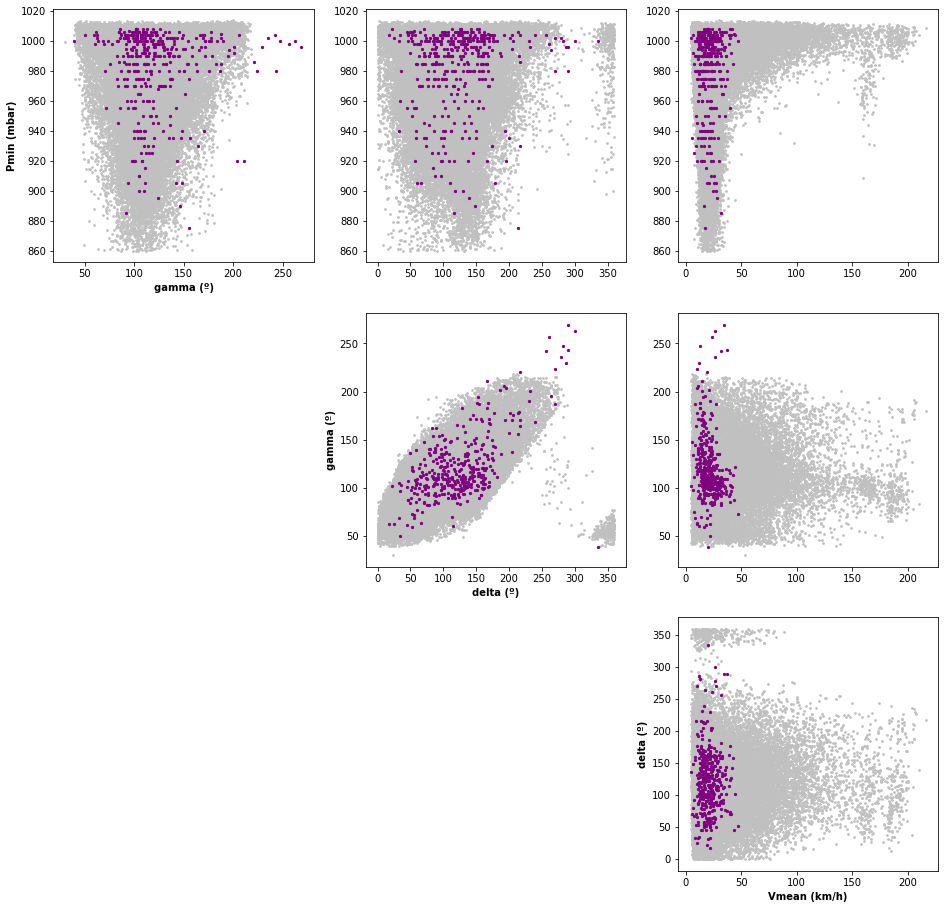

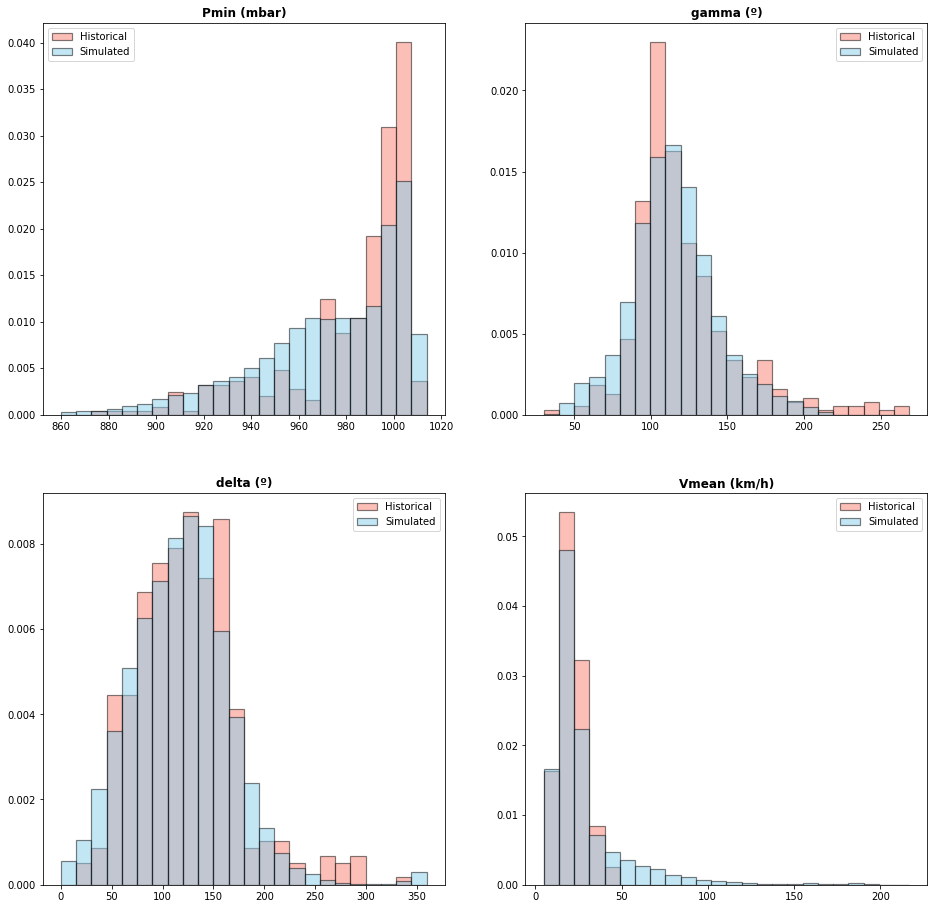

In [5]:
# Historical vs Nakajo Simulation parameters: 
_, TCs_r2_hist_params = db.Load_TCs_r2_hist()  # historical TCs parameters inside radius 2

# scatter plot
Plot_TCs_Params_HISTvsSIM(TCs_r2_hist_params, TCs_r2_sim_params);

# histogram
Plot_TCs_Params_HISTvsSIM_histogram(TCs_r2_hist_params, TCs_r2_sim_params);



## Simulated TCs - MaxDiss classification

In [6]:
# --------------------------------------
# MaxDiss classification

# get simulated parameters  
pmean_s = TCs_r2_sim_params.pressure_mean.values[:]
pmin_s  = TCs_r2_sim_params.pressure_min.values[:]
gamma_s = TCs_r2_sim_params.gamma.values[:]
delta_s = TCs_r2_sim_params.delta.values[:]
vmean_s = TCs_r2_sim_params.velocity_mean.values[:]

# subset, scalar and directional indexes
data_mda = np.column_stack((pmean_s, pmin_s, vmean_s, delta_s, gamma_s))
ix_scalar = [0,1,2]
ix_directional = [3,4]

# MDA
centroids = MaxDiss_Simplified_NoThreshold(
    data_mda, num_sel_mda, ix_scalar, ix_directional 
)


# store MDA storms - parameters 
TCs_r2_MDA_params = xr.Dataset(
    {
        'pressure_mean':(('storm'), centroids[:,0]),
        'pressure_min':(('storm'), centroids[:,1]),
        'velocity_mean':(('storm'), centroids[:,2]),
        'delta':(('storm'), centroids[:,3]),
        'gamma':(('storm'), centroids[:,4]),
    },
    coords = {
        'storm':(('storm'), np.arange(num_sel_mda))    
    },
)
print(TCs_r2_MDA_params)

db.Save_TCs_r2_mda_params(TCs_r2_MDA_params)



MaxDiss waves parameters: 55525 --> 1000

   MDA centroids: 1000/1000

<xarray.Dataset>
Dimensions:        (storm: 1000)
Coordinates:
  * storm          (storm) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    pressure_mean  (storm) float64 1.014e+03 863.5 999.5 ... 992.0 1.008e+03
    pressure_min   (storm) float64 1.013e+03 861.5 999.3 ... 990.8 1.008e+03
    velocity_mean  (storm) float64 47.77 21.45 203.7 20.98 ... 7.285 192.5 127.1
    delta          (storm) float64 217.1 31.56 37.23 213.1 ... 165.1 102.1 159.7
    gamma          (storm) float64 183.3 75.81 96.39 147.4 ... 140.4 99.9 165.9


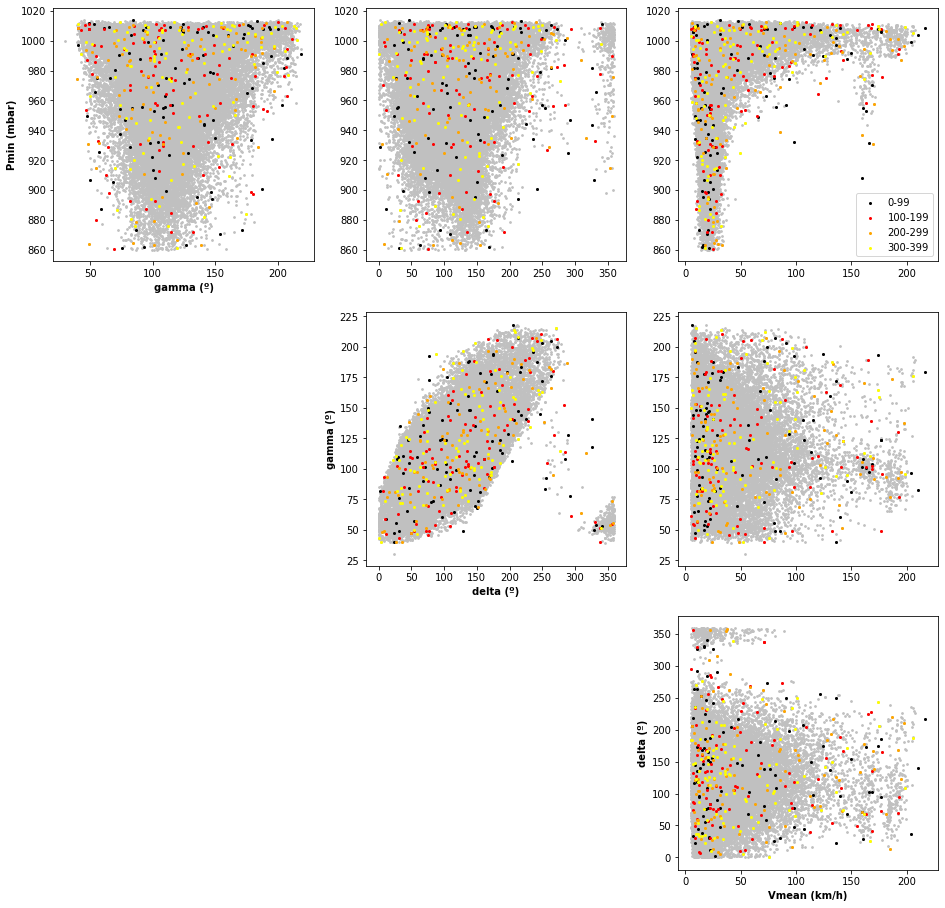

In [7]:
# Historical vs Simulated: scatter plot parameters
Plot_TCs_Params_MDAvsSIM(TCs_r2_MDA_params, TCs_r2_sim_params);


## Nakajo TCs (MDA centroids) Waves Simulation

Waves data is generated by numerically simulating selected storms. 

This methodology is not included inside teslakit python library.

This step needs to be done before continuing with notebook 05
